# **Lab 5**

# **Phát hiện bất thường mạng sử dụng mô hình LSTM**
Trong bài thực hành này, ta sẽ tạo và huấn luyện mô hình LSTM để phát hiện điểm bất thường trên tập dữ liệu lưu lượng mạng KDD99.


# **A. Hướng dẫn xây dựng mô hình phân loại 2 lớp**





## **1. Đọc tập dữ liệu KDD99**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

2144903/2144903 [==============================] - 1s 1us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header, ta thêm vào các header sau
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

## **3. Encode dữ liệu số và chữ**

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
        df[dummy_name] = df[dummy_name].map({True: 1, False: 0})
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-7-912d40b9744c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-7-912d40b9744c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-7-912d40b9744c>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
df['protocol_type-tcp'].unique()

array([1, 0])

In [ ]:
df['outcome']

0         normal.
1         normal.
2         normal.
3         normal.
4         normal.
           ...   
494016    normal.
494017    normal.
494018    normal.
494019    normal.
494020    normal.
Name: outcome, Length: 494021, dtype: object

In [ ]:
df.loc[df["outcome"] != "normal.", "outcome"] = 1
df.loc[df["outcome"] == "normal.", "outcome"] = 0

In [ ]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148207, 120), (148207,))


In [ ]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

In [ ]:
y_train.shape
y_test.shape

TensorShape([148207, 2])

## **4. Kiến trúc mô hình LSTM**

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='softmax'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 17026 (66.51 KB)
Trainable params: 17026 (66.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=3,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/3
271/271 [==============================] - 228s 828ms/step - loss: 0.0907 - accuracy: 0.8913 - val_loss: 0.0183 - val_accuracy: 0.9748
Epoch 2/3
271/271 [==============================] - 232s 858ms/step - loss: 0.0155 - accuracy: 0.9805 - val_loss: 0.0195 - val_accuracy: 0.9769
Epoch 3/3
271/271 [==============================] - 228s 842ms/step - loss: 0.0133 - accuracy: 0.9846 - val_loss: 0.0114 - val_accuracy: 0.9881


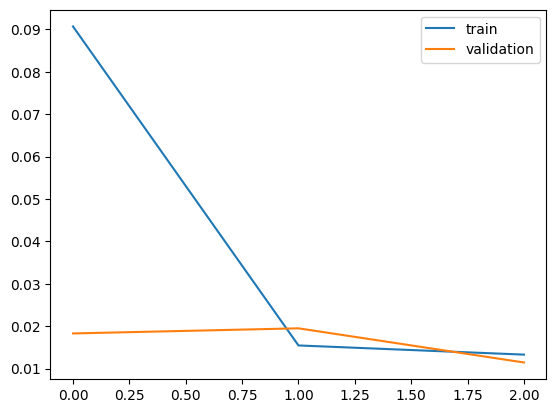

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

## **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 [==============================] - 119s 351ms/step - loss: 0.0112 - accuracy: 0.9884


# **B. Bài tập**


1.   **Yêu cầu 1 (Tại lớp): Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**
2.   **Yêu cầu 2 (Về nhà): Sinh viên chạy lại tập dữ liệu [CIC IDS 2018](https://www.unb.ca/cic/datasets/ids-2018.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**





# Yêu cầu 1:

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [ ]:
from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

In [ ]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [ ]:
# CSV không có header, thêm các header name này vào
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
# loại bỏ NA
df.dropna(inplace=True,axis=1)
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

In [ ]:
# Encode cột số
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cột chữ ([1,0,0],[0,1,0],[0,0,1] cho red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
        df[dummy_name] = df[dummy_name].map({True: 1, False: 0})
    df.drop(name, axis=1, inplace=True)

In [ ]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-34-08f97daadff8>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-34-08f97daadff8>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-34-08f97daadff8>:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,0,1,0,1,0,0,1,1,1,0


In [ ]:
df['protocol_type-tcp'].unique()

array([1, 0])

In [ ]:
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 97278
Attack count: 396743


In [ ]:
# feature vector
x_normal = df_normal.values
x_attack = df_attack.values

In [ ]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.3, random_state=12)

print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 68094
Normal test count: 29184


In [ ]:
x_normal_train.shape, x_normal_test.shape

((68094, 120), (29184, 120))

In [ ]:
#Chia tỷ lệ tập dữ liệu
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_normal_train = sc.fit_transform(x_normal_train)
x_normal_test = sc.fit_transform(x_normal_test)
x_normal = sc.fit_transform(x_normal)
x_attack = sc.fit_transform(x_attack)

In [ ]:
x_normal_train = pd.DataFrame(x_normal_train)
x_normal_test = pd.DataFrame(x_normal_test)
x_attack = pd.DataFrame(x_attack)
x_normal = pd.DataFrame(x_normal)

In [ ]:
#Hàm convert time domain dữ liệu
def create_dataset(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [ ]:
# reshape [samples, time_steps, n_features]

TIME_STEPS = 1
Xnormal_train = create_dataset(x_normal_train, TIME_STEPS)
print(Xnormal_train.shape)

(68093, 1, 120)


In [ ]:
Xnormal_test = create_dataset(x_normal_test, TIME_STEPS)
print(Xnormal_test.shape)

(29183, 1, 120)


In [ ]:
Xattack = create_dataset(x_attack, TIME_STEPS)
print(Xattack.shape)

(396742, 1, 120)


In [ ]:
Xnormal = create_dataset(x_normal,TIME_STEPS)
print(Xattack.shape)

(396742, 1, 120)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=64, input_shape=(Xnormal_train.shape[1], Xnormal_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.RepeatVector(n=Xnormal_train.shape[1]))
model.add(keras.layers.LSTM(units=32, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=Xnormal_train.shape[2])))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                47360     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 1, 64)             0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 1, 32)             12416     
                                                                 
 dropout_3 (Dropout)         (None, 1, 32)             0         
                                                                 
 time_distributed_1 (TimeDi  (None, 1, 120)            3960      
 stributed)                                           

In [ ]:
history = model.fit(
    Xnormal_train, Xnormal_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/15
426/426 [==============================] - 12s 17ms/step - loss: 0.1023 - accuracy: 0.1571 - val_loss: 0.0643 - val_accuracy: 0.2273
Epoch 2/15
426/426 [==============================] - 3s 7ms/step - loss: 0.0633 - accuracy: 0.2791 - val_loss: 0.0502 - val_accuracy: 0.4107
Epoch 3/15
426/426 [==============================] - 3s 7ms/step - loss: 0.0585 - accuracy: 0.3398 - val_loss: 0.0484 - val_accuracy: 0.4143
Epoch 4/15
426/426 [==============================] - 4s 9ms/step - loss: 0.0562 - accuracy: 0.3965 - val_loss: 0.0472 - val_accuracy: 0.4688
Epoch 5/15
426/426 [==============================] - 4s 11ms/step - loss: 0.0540 - accuracy: 0.4144 - val_loss: 0.0462 - val_accuracy: 0.4682
Epoch 6/15
426/426 [==============================] - 3s 7ms/step - loss: 0.0519 - accuracy: 0.4102 - val_loss: 0.0438 - val_accuracy: 0.4678
Epoch 7/15
426/426 [==============================] - 3s 7ms/step - loss: 0.0503 - accuracy: 0.4152 - val_loss: 0.0429 - val_accuracy: 0.4710
Epo

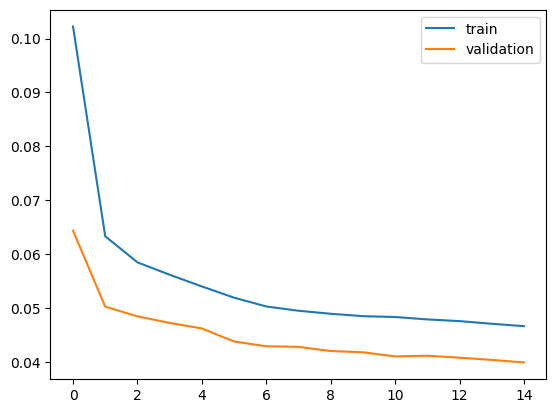

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [ ]:
#Đánh giá mô hình
X_train_pred = model.predict(Xnormal_train)

train_mae_loss = np.mean(np.abs(X_train_pred - Xnormal_train), axis=1)
train_mae_loss.shape

2128/2128 [==============================] - 6s 2ms/step


(68093, 120)

In [ ]:
X_normal_pred = model.predict(Xnormal)

normal_mae_loss = np.mean(np.abs(X_normal_pred - Xnormal), axis=1)
normal_mae_loss.shape

3040/3040 [==============================] - 9s 3ms/step


(97277, 120)

In [ ]:
score1 = model.evaluate(Xnormal_train, Xnormal_train)
print("\n Sample Loss(MAE) & Accuracy Scores (Train):", score1[0], score1[1], "\n")

score2 = model.evaluate(Xnormal_test, Xnormal_test)
print("\nOut of Sample Loss(MAE) & Accuracy Scores (Test):", score2[0], score2[1], "\n")

score3 = model.evaluate(Xattack, Xattack)
print("\nAttack Underway Loss(MAE) & Accuracy Scores (Anomaly):", score3[0], score3[1], "\n")

2128/2128 [==============================] - 7s 3ms/step - loss: 0.0394 - accuracy: 0.5830

 Sample Loss(MAE) & Accuracy Scores (Train): 0.03941570222377777 0.5829674005508423 

912/912 [==============================] - 3s 3ms/step - loss: 0.0415 - accuracy: 0.5873

Out of Sample Loss(MAE) & Accuracy Scores (Test): 0.04152890667319298 0.5872597098350525 

12399/12399 [==============================] - 32s 3ms/step - loss: 0.1606 - accuracy: 0.0565

Attack Underway Loss(MAE) & Accuracy Scores (Anomaly): 0.16060858964920044 0.05646742880344391 



# **Yêu cầu 2**
Để thực hiện yêu cầu này, ta cần cài đặt AWS CLI

In [ ]:
%cd /content/drive/MyDrive/Lab5/
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip -o awscliv2.zip

Streaming output truncated to the last 5000 lines.
  inflating: aws/dist/awscli/examples/eks/describe-update.rst  
  inflating: aws/dist/awscli/examples/eks/update-cluster-version.rst  
  inflating: aws/dist/awscli/examples/eks/create-cluster.rst  
  inflating: aws/dist/awscli/examples/eks/update-cluster-config.rst  
  inflating: aws/dist/awscli/examples/eks/list-identity-provider-configs.rst  
  inflating: aws/dist/awscli/examples/eks/associate-identity-provider-config.rst  
  inflating: aws/dist/awscli/examples/eks/delete-addon.rst  
  inflating: aws/dist/awscli/examples/eks/tag-resource.rst  
  inflating: aws/dist/awscli/examples/eks/delete-fargate-profile.rst  
  inflating: aws/dist/awscli/examples/eks/describe-fargate-profile.rst  
  inflating: aws/dist/awscli/examples/eks/disassociate-identity-provider-config.rst  
  inflating: aws/dist/awscli/examples/eks/describe-nodegroup.rst  
  inflating: aws/dist/awscli/examples/eks/create-addon.rst  
  inflating: aws/dist/awscli/examples/e

In [ ]:
! ./aws/install # --update

You can now run: /usr/local/bin/aws --version


In [ ]:
! /usr/local/bin/aws --version

aws-cli/2.15.53 Python/3.11.8 Linux/6.1.85+ exe/x86_64.ubuntu.22


In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/" # Dùng lệnh "ls" để xem list danh sách file và thư mục

                           PRE Original Network Traffic and Log data/
                           PRE Processed Traffic Data for ML Algorithms/


Ta sẽ sử dụng file csv trong thư mục Processed Trafic Data for ML Algorithms

In [ ]:
!aws s3 ls --no-sign-request --region us-east-2 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/"

2018-10-11 16:02:25          0 
2018-10-11 16:02:49  352368373 Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:10  333723605 Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:33  382840456 Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:59 4054925350 Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:38  107842858 Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:48  375945899 Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:20  382636202 Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:44  358223333 Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:12  328893673 Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:33  209249758 Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv


Nên sử dụng 1 file csv để làm lab này vì sử dụng hết sẽ rất nặng

In [ ]:
!aws s3 sync --no-sign-request --region us-east-2 --exclude "*" --include "Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv" "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/" .

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.utils import get_file

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Lab5/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv", nrows=200000)
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15/02/2018 08:25:18,112641158,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320579.0,7.042784e+02,56321077,56320081,Benign
1,22,6,15/02/2018 08:29:05,37366762,14,12,2168,2993,712,0,...,32,1024353.0,649038.754495,1601183,321569,11431221.0,3.644991e+06,15617415,8960247,Benign
2,47514,6,15/02/2018 08:29:42,543,2,0,64,0,64,0,...,32,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
3,0,0,15/02/2018 08:28:07,112640703,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320351.5,3.669884e+02,56320611,56320092,Benign
4,0,0,15/02/2018 08:30:56,112640874,3,0,0,0,0,0,...,0,0.0,0.000000,0,0,56320437.0,7.198347e+02,56320946,56319928,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,53,17,15/02/2018 09:20:30,37205,1,1,32,154,32,32,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
199996,53,17,15/02/2018 09:47:06,1136,1,1,31,112,31,31,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
199997,53,17,15/02/2018 08:30:08,23786,1,1,34,139,34,34,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign
199998,53,17,15/02/2018 09:06:27,483,1,1,36,52,36,36,...,8,0.0,0.000000,0,0,0.0,0.000000e+00,0,0,Benign


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Dst Port           200000 non-null  int64  
 1   Protocol           200000 non-null  int64  
 2   Timestamp          200000 non-null  object 
 3   Flow Duration      200000 non-null  int64  
 4   Tot Fwd Pkts       200000 non-null  int64  
 5   Tot Bwd Pkts       200000 non-null  int64  
 6   TotLen Fwd Pkts    200000 non-null  int64  
 7   TotLen Bwd Pkts    200000 non-null  int64  
 8   Fwd Pkt Len Max    200000 non-null  int64  
 9   Fwd Pkt Len Min    200000 non-null  int64  
 10  Fwd Pkt Len Mean   200000 non-null  float64
 11  Fwd Pkt Len Std    200000 non-null  float64
 12  Bwd Pkt Len Max    200000 non-null  int64  
 13  Bwd Pkt Len Min    200000 non-null  int64  
 14  Bwd Pkt Len Mean   200000 non-null  float64
 15  Bwd Pkt Len Std    200000 non-null  float64
 16  Fl

In [ ]:
df.groupby('Label')['Label'].count()

Label
Benign                   147502
DoS attacks-GoldenEye     41508
DoS attacks-Slowloris     10990
Name: Label, dtype: int64

In [ ]:
# Xóa các cột chỉ có 1 giá trị
def distinct_val_of_columns(dataset):
    columns = dataset.columns
    num_val = []
    for column in columns:
        num_val.append(len(dataset[column].unique()))

    col_val_df = pd.DataFrame({'Column': columns, 'Distinct Value': num_val})
    single_val_cols = col_val_df[col_val_df['Distinct Value'] == 1]
    return col_val_df, single_val_cols

In [ ]:
# Xóa các cột chỉ có 1 giá trị
col_val_df, single_val_cols = distinct_val_of_columns(df)
df = df.drop(columns= single_val_cols['Column'].values)

# Sắp xếp các record theo thời gian
df = df.sort_values(by=["Timestamp"], ascending=True)

df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
108690,3389,6,15/02/2018 01:00:00,3686219,10,11,1272,1893,677,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
95790,3389,6,15/02/2018 01:00:01,2465495,8,7,1128,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
65323,3389,6,15/02/2018 01:00:01,2502937,8,7,1128,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
136781,51773,6,15/02/2018 01:00:01,3,3,0,31,0,31,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
188146,80,6,15/02/2018 01:00:02,79,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79503,3389,6,15/02/2018 12:59:57,1584311,8,7,1132,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
124787,3389,6,15/02/2018 12:59:57,2841919,8,7,1128,1581,661,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
128060,3389,6,15/02/2018 12:59:57,3452438,11,12,2632,1677,677,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
82070,51268,6,15/02/2018 12:59:59,46,1,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


In [ ]:
df.drop('Timestamp', axis=1, inplace=True)

In [ ]:
df.dropna(inplace=True,axis=1)
df.shape

(200000, 68)

In [ ]:
# Encode các number values
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Encode cho categorical values
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
        df[dummy_name] = df[dummy_name].map({True: 1, False: 0})
    df.drop(name, axis=1, inplace=True)

In [ ]:
text_col = []

for i in range(df.shape[1]):
  if str(df.dtypes[i]) != "int64" and str(df.dtypes[i]) != "float64":
    if str(df.columns[i]) != "Label":
      text_col.append(df.columns[i])

In [ ]:
#encoding feature vector
for i in df.columns:
  if i not in text_col:
    if i != 'Label':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

In [ ]:
df.dropna(inplace=True,axis=1)
df[0:5]

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
108690,-0.146828,-0.557717,-0.382600,0.166139,0.053989,0.005821,-0.020829,1.265176,-0.502715,0.816554,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
95790,-0.146828,-0.557717,-0.417813,0.098496,0.010222,0.003636,-0.023279,1.225087,-0.502715,0.964799,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
65323,-0.146828,-0.557717,-0.416733,0.098496,0.010222,0.003636,-0.023279,1.225087,-0.502715,0.964799,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
136781,2.938113,-0.557717,-0.488933,-0.070610,-0.066370,-0.013007,-0.035690,-0.353405,-0.502715,-0.438873,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign
188146,-0.357808,-0.557717,-0.488931,-0.104431,-0.066370,-0.013477,-0.035690,-0.431077,-0.502715,-0.549878,...,0.008693,-0.196099,-0.187984,-0.213869,-0.177945,-0.356449,-0.176218,-0.372576,-0.332321,Benign


In [ ]:
normal_mask = df['Label']=='Benign'
attack_mask = df['Label']!='Benign'

df.drop('Label',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 147502
Attack count: 52498


In [ ]:
# feature vector
x_normal = df_normal.values
x_attack = df_attack.values

In [ ]:
from sklearn.model_selection import train_test_split

x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.3, random_state=12)

print(f"Normal train count: {len(x_normal_train)}")
print(f"Normal test count: {len(x_normal_test)}")

Normal train count: 103251
Normal test count: 44251


In [ ]:
x_normal_train.shape, x_normal_test.shape

((103251, 66), (44251, 66))

In [ ]:
#Chia tỷ lệ tập dữ liệu
from sklearn.preprocessing import MinMaxScaler

mmc = MinMaxScaler()

x_normal_train = mmc.fit_transform(x_normal_train)
x_normal_test = mmc.fit_transform(x_normal_test)
x_normal = mmc.fit_transform(x_normal)
x_attack = mmc.fit_transform(x_attack)

In [ ]:
x_normal_train = pd.DataFrame(x_normal_train)
x_normal_test = pd.DataFrame(x_normal_test)
x_attack = pd.DataFrame(x_attack)
x_normal = pd.DataFrame(x_normal)

In [ ]:
#Convert time step dữ liệu
def create_dataset(X, time_steps):
    Xs = []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
    return np.array(Xs)

In [ ]:
# reshape [samples, time_steps, n_features]

TIME_STEPS = 1
Xnormal_train = create_dataset(x_normal_train, TIME_STEPS)
print(Xnormal_train.shape)

(103250, 1, 66)


In [ ]:
Xnormal_test = create_dataset(x_normal_test, TIME_STEPS)
print(Xnormal_test.shape)

(44250, 1, 66)


In [ ]:
Xattack = create_dataset(x_attack, TIME_STEPS)
print(Xattack.shape)

(52497, 1, 66)


In [ ]:
Xnormal = create_dataset(x_normal,TIME_STEPS)
print(Xattack.shape)

(52497, 1, 66)


In [ ]:
model = keras.Sequential() # Sử dụng model chuỗi, vì đây dạng dữ liệu liên tục được ghi nhận trong một khoảng thời gian
model.add(keras.layers.LSTM(units=64, input_shape=(Xnormal_train.shape[1], Xnormal_train.shape[2]))) # Đây là lớp điển hình của mô hình đang build, có tính chất nhớ từ kết quả training
model.add(keras.layers.Dropout(rate=0.2)) # Ngẫu nhiên loại bỏ một phần unit
# Hay nói cách khác là 1 hidden unit không thể dựa vào 1 unit khác để sửa lỗi lầm của nó, dễ cho chúng ta thấy các hidden unit không đáng tin cậy
# --> Chống overfit

model.add(keras.layers.RepeatVector(n=Xnormal_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True)) # Chỉnh 'unit' từ 32->64
model.add(keras.layers.Dropout(rate=0.2)) # Chỉnh từ 0.5->0.2
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=Xnormal_train.shape[2])))

model.compile(loss="mse", optimizer='adam', metrics=['accuracy']) # Ở đây loss function ta dùng 'mse' sẽ cho kết quả cao hơn và hội tụ nhanh hơn
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                33536     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 repeat_vector_2 (RepeatVec  (None, 1, 64)             0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 1, 64)             33024     
                                                                 
 dropout_5 (Dropout)         (None, 1, 64)             0         
                                                                 
 time_distributed_2 (TimeDi  (None, 1, 66)             4290      
 stributed)                                           

In [ ]:
# traning model
history = model.fit(
    Xnormal_train, Xnormal_train,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/15
646/646 [==============================] - 13s 13ms/step - loss: 0.0062 - accuracy: 0.8452 - val_loss: 8.8264e-04 - val_accuracy: 0.8738
Epoch 2/15
646/646 [==============================] - 5s 8ms/step - loss: 0.0020 - accuracy: 0.8618 - val_loss: 5.5176e-04 - val_accuracy: 0.8942
Epoch 3/15
646/646 [==============================] - 8s 12ms/step - loss: 0.0017 - accuracy: 0.8566 - val_loss: 4.3098e-04 - val_accuracy: 0.8845
Epoch 4/15
646/646 [==============================] - 5s 8ms/step - loss: 0.0015 - accuracy: 0.8567 - val_loss: 4.0676e-04 - val_accuracy: 0.8972
Epoch 5/15
646/646 [==============================] - 7s 11ms/step - loss: 0.0014 - accuracy: 0.8558 - val_loss: 3.3956e-04 - val_accuracy: 0.8995
Epoch 6/15
646/646 [==============================] - 6s 10ms/step - loss: 0.0013 - accuracy: 0.8558 - val_loss: 3.0370e-04 - val_accuracy: 0.8961
Epoch 7/15
646/646 [==============================] - 5s 8ms/step - loss: 0.0013 - accuracy: 0.8561 - val_loss: 2.7751e

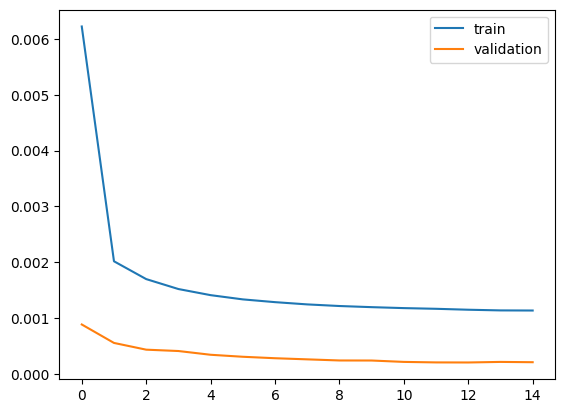

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

In [ ]:
# model evalutation
X_train_pred = model.predict(Xnormal_train)

train_mse_loss = np.mean(np.abs(X_train_pred - Xnormal_train), axis=1)
train_mse_loss.shape

3227/3227 [==============================] - 14s 4ms/step


(103250, 66)

In [ ]:
X_normal_pred = model.predict(Xnormal)

normal_mse_loss = np.mean(np.abs(X_normal_pred - Xnormal), axis=1)
normal_mse_loss.shape

4610/4610 [==============================] - 15s 3ms/step


(147501, 66)

In [ ]:
score1 = model.evaluate(Xnormal_train, Xnormal_train)
print("\n Sample Loss(MSE) & Accuracy Scores (Train):", score1[0], score1[1], "\n")

score2 = model.evaluate(Xnormal_test, Xnormal_test)
print("\nOut of Sample Loss(MSE) & Accuracy Scores (Test):", score2[0], score2[1], "\n")

score3 = model.evaluate(Xattack, Xattack)
print("\nAttack Underway Loss(MSE) & Accuracy Scores (Anomaly):", score3[0], score3[1], "\n")

3227/3227 [==============================] - 8s 3ms/step - loss: 2.0873e-04 - accuracy: 0.9014

 Sample Loss(MSE) & Accuracy Scores (Train): 0.00020872551249340177 0.9013656377792358 

1383/1383 [==============================] - 3s 2ms/step - loss: 4.2451e-04 - accuracy: 0.9034

Out of Sample Loss(MSE) & Accuracy Scores (Test): 0.0004245125746820122 0.903412401676178 

1641/1641 [==============================] - 5s 3ms/step - loss: 0.0590 - accuracy: 0.5543

Attack Underway Loss(MSE) & Accuracy Scores (Anomaly): 0.058966636657714844 0.5543174147605896 

